<a href="https://colab.research.google.com/github/RapaDewan/CSE499_work/blob/main/CSE499A_implementation_1/CSE499A_implementation_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install python-pdfbox
!pip install pyLDAvis
!pip install skillNer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.9/82.9 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.8/493.8 kB 11.1 MB/s eta 0:00:00
  Created wheel for python-pdfbox: filename=python_pdfbox-0.1.8.1-py3-none-any.whl size=6181 sha256=de05a8cbcd4f7a66792c717cfd88b5149482d871128853ec607d9a683d3b58ae
  Stored in directory: /root/.cache/pip/wheels/43/ae/ed/9a8acbfb2ee61070102a840e01755d0ef38940f1ef4cbe45e4
Successfully built python-pdfbox
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 25.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for skillNer: filename=skillNer-1.0.3-py3-none-any.whl size=25625 sha256=bbc43f382f01e56c65ddc03ec6f3f8b98d5a895d2f1a7a3957aa077cdceedc08
  Stored in directory: /root/.cache/pip/wheels/9a/f1/7a/3201e01141cdb862654585eb16412785ed9973459639c351e4
Successfully built skillNer


In [2]:
import csv
import os
import glob
import re
import nltk
import spacy
from spacy.pipeline import EntityRuler
from spacy.lang.en import English
from spacy.tokens import Doc
import gensim
from gensim import corpora
import plotly.express as px
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

from pdfbox import PDFBox
import hashlib # file ids
import spacy.cli
spacy.cli.download("en_core_web_lg")
#warning
import warnings
warnings.filterwarnings('ignore')

nltk.download(['stopwords','wordnet'])

nltk.download('omw-1.4')
nlp=spacy.load('en_core_web_lg')

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
def extract_pdf_text(folder_path):
    text_list = []

    for file in glob.glob(os.path.join(folder_path, "*.pdf")):
        file_name = os.path.basename(file)
        pdf = PDFBox()
        text = pdf.extract_text(file)
        if text:
            text_list.append({"file_name": file_name, "text": text})
        else:
            with open(f"{file_name}.txt", "w") as f:
                f.write("")


In [23]:
def text_to_csv(folder_path):
    csv_file = open('text_files.csv', 'w', newline='')
    writer = csv.writer(csv_file)
    writer.writerow(['ID', 'filename', 'text'])

    def generate_id(filename):
        return int(hashlib.md5(filename.encode('utf-8')).hexdigest(), 16)% 100000 #to limit the unique ID to less or equal to 5 digits

    for filename in os.listdir(folder_path):
        if filename.endswith(".txt"):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'r') as file:
                text = file.read()
                id = generate_id(filename)
                writer.writerow([id, filename, text])

    csv_file.close()


In [24]:
def load_csv(file_path):
    df = pd.read_csv(file_path)
    return df

In [25]:
from spacy.matcher import PhraseMatcher

# load default skills data base
from skillNer.general_params import SKILL_DB
# import skill extractor
from skillNer.skill_extractor_class import SkillExtractor
skill_extractor = SkillExtractor(nlp, SKILL_DB, PhraseMatcher)

loading full_matcher ...
loading abv_matcher ...
loading full_uni_matcher ...
loading low_form_matcher ...
loading token_matcher ...


In [26]:
def extract_skills(text):

    annotations = skill_extractor.annotate(text)
    doc_node_values = set([x['doc_node_value'] for x in annotations['results']['full_matches']])
    return ', '.join(doc_node_values)

In [27]:
def create_wordcloud(df, column_name):
    skill_cloud = ""
    for i in df[column_name].values:
        skill_cloud += i + " "

    plt.figure(figsize=(8, 8))

    x, y = np.ogrid[:300, :300]

    mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
    mask = 255 * mask.astype(int)

    wc = WordCloud(
        width=800,
        height=800,
        background_color="white",
        min_font_size=6,
        repeat=True,
        mask=mask,
    )
    wc.generate(skill_cloud)
    plt.axis("off")
    plt.imshow(wc, interpolation="bilinear")
    plt.title("Most Used Skill Words in Resume", fontsize=20)

In [28]:
def plot_skills_histogram(df):
    df_skills = df.copy()
    df_skills['skills'] = df_skills['skills'].str.split(',')
    df_skills = df_skills.set_index(['ID'])['skills'].apply(pd.Series).stack()
    df_skills = df_skills.reset_index()
    df_skills = df_skills.rename(columns={0: "skill"})
    df_skills['skill'].value_counts().plot(kind='bar')
    plt.xlabel("Skills")
    plt.ylabel("Number of Candidates")
    plt.title("Skills Histogram")
    plt.show()

In [36]:
!pip install PyPDF2

from PyPDF2 import PdfReader
import os
import glob

def extract_pdf_text(folder_path):
    for file in glob.glob(os.path.join(folder_path, "*.pdf")):
        file_name = os.path.basename(file)
        try:
            reader = PdfReader(file)
            text = ""
            for page in reader.pages:
                text += page.extract_text()
            # Save extracted text into a .txt file
            txt_file_path = os.path.join(folder_path, f"{file_name}.txt")
            with open(txt_file_path, "w", encoding="utf-8") as f:
                f.write(text)
            print(f"Extracted text from: {file_name}")
        except Exception as e:
            print(f"Failed to extract text from {file_name}: {e}")

# Example usage
folder_path = "/content/drive/MyDrive/Uploaded Resumes"
extract_pdf_text(folder_path)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 4.0 MB/s eta 0:00:00
Extracted text from: Junchao Zheng.pdf
Extracted text from: Nabeel Vandayar.pdf
Extracted text from: Dennis Tran.pdf
Extracted text from: Lindani Moyo.pdf
Extracted text from: Sam Ariabod.pdf


RuntimeError: failed to verify sha512sum

In [37]:
# To create a csv file from the extracted text
text_to_csv(folder_path)

In [38]:
# To load the csv file
file_path = 'text_files.csv'
df = load_csv(file_path)

In [39]:
# To preprocess the text in the csv file
clean = []
for i in range(df.shape[0]):
    review = re.sub(
        '(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?"',
        " ",
        df["text"].iloc[i],
    )
    review = review.lower()
    review = review.split()
    lm = WordNetLemmatizer()
    review = [
        lm.lemmatize(word)
        for word in review
        if not word in set(stopwords.words("english"))
    ]
    review = " ".join(review)
    clean.append(review)

df["Clean_Resume"] = clean

In [41]:
df['skills'] = df['Clean_Resume'].apply(extract_skills)
df.head()

,ID,filename,text,Clean_Resume,skills
0,83588,Junchao Zheng.pdf.txt,\n联系方式\nwww.linkedin.com/in/\njunchaozheng8...,www linkedin com junchaozheng819 linkedin pyth...,"capital market, machine learn, market research..."
1,35790,Nabeel Vandayar.pdf.txt,\nContact\nwww.linkedin.com/in/nabeel-\nvan...,contact www linkedin com nabeel vandayar linke...,"distribute database, big datum, machine learn,..."
2,51263,Dennis Tran.pdf.txt,\nContact\nwww.linkedin.com/in/dennisdt\n(L...,contact www linkedin com dennisdt linkedin top...,"mechanical engineering, erp, user account, mac..."
3,65352,Lindani Moyo.pdf.txt,\nContact\nwww.linkedin.com/in/lindani-\nmo...,contact www linkedin com lindani moyo 0a880884...,"computer science, com, information system, mac..."
4,98512,Sam Ariabod.pdf.txt,\nContact\nwww.linkedin.com/in/sariabod\n(L...,contact www linkedin com sariabod linkedin top...,"emerge technology, software development, app d..."


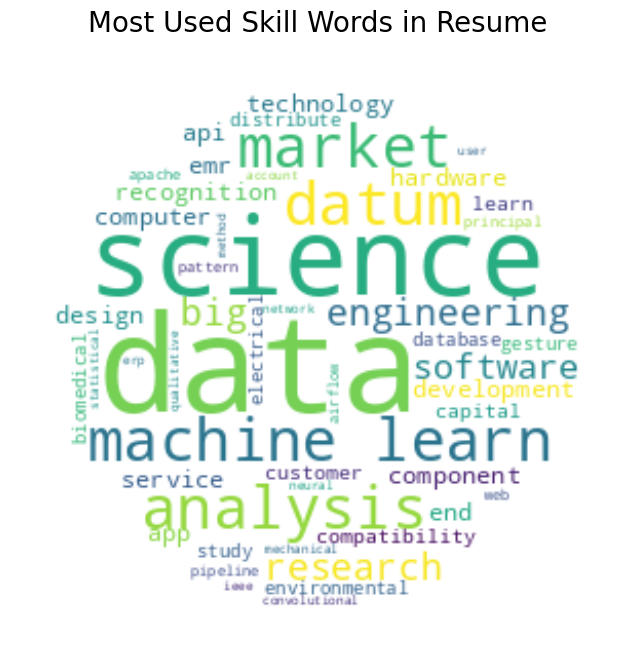

In [42]:
create_wordcloud(df, "skills")
def rank_resumes(df, keywords, scores):
    scores_dict = dict(zip(keywords, scores))
    df["rank"] = 0
    for i in range(df.shape[0]):
        for keyword in keywords:
            if keyword in df["skills"].iloc[i]:
                df["rank"].iloc[i] += scores_dict[keyword]
    df = df.sort_values("rank", ascending=False)
    return df
keywords = ['business development','machine learn', 'time management']# key words to be searched in skills
scores = [2, 3]# scores for the above skills in respective order
df = rank_resumes(df, keywords, scores)
df.to_csv('/content/drive/MyDrive/Uploaded Resumes/ranked_resumesBA.csv', index=False)